# Build a Retrieval Augmented Generation (RAG) App: Part 1

- Build a Retrieval Augmented Generation (RAG) App: Part 1( https://python.langchain.com/docs/tutorials/rag/ )
  - RAGを用いたシンプルなQ&Aアプリケーションの例

## RAGにおける2つの要素
- `Indexing`
  - 外部ストアに固有のデータを保存する
  - `Load`,`Split`,`Store`の3ステップから成る
- `Retrieval and Generation`
  - 入力に基づいてストアを検索し、そこで得た結果を使ってLLMが回答を生成する

### パッケージインストール

In [35]:
%pip install -qU langchain-text-splitters langchain-community langgraph langsmith


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [36]:
%pip install -qU langchain langchain-openai langchain-core


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [37]:
%pip install -qU python-dotenv


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [38]:
%pip install -qU bs4


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### 環境変数の読み込み
- `OPENAI_API_KEY`
- `LANGSMITH_API_KEY`

In [39]:
from dotenv import load_dotenv
import os

load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_PROJECT"] = "langchain-rag"

### モデルの作成

In [40]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

### Embeddingモデルの作成

- Embeddings Modelの料金( https://platform.openai.com/docs/pricing#embeddings )

In [41]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

### Vector Storeの作成
- `InMemoryVectorStore`( https://python.langchain.com/api_reference/core/vectorstores/langchain_core.vectorstores.in_memory.InMemoryVectorStore.html )

In [42]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

## Indexing

### データの取得(Load)
- `bs4`はHTMLからデータを取り出すためのパッケージ
  - `Beautiful Soup`( https://beautiful-soup-4.readthedocs.io/en/latest/#beautifulsoup )
  - `SoupStrainer()`( https://beautiful-soup-4.readthedocs.io/en/latest/#soupstrainer )

In [43]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# データの取得
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(  # HTMLをテキストに変換
            class_=("post-content", "post-title", "post-header")  # 3つのクラスに対応するHTMLタグのテキストのみを取得
        )
    ),
)
docs = loader.load()  # 取得したdocはken=1のlist[Document]

# データ量の確認
assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")
print(docs[0].page_content[:200])

Total characters: 43130


      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a 


### データの分割(Splitting)
- 取得したテキストを分割してモデルのContext Windowに収まるようにする
  - How to recursively split text by characters( https://python.langchain.com/docs/how_to/recursive_text_splitter/ )
  - `RecursiveCharacterTextSplitter`( https://python.langchain.com/api_reference/text_splitters/character/langchain_text_splitters.character.RecursiveCharacterTextSplitter.html )
  - 改行やスペースなどを区切りとしてテキストを分割することで文章の意味を損なわないようにchunkに分割する

In [44]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} chunks.")
print(f"len(all_splits[0].page_content): {len(all_splits[0].page_content)}")

Split blog post into 66 chunks.
len(all_splits[0].page_content): 969


### VectorStoreへのデータ登録(Storing)
- chunkに分割したデータを`Embeddingモデル`でベクトル化して`VectorStore`に保存(ベクトル化されたデータのことを`埋め込み(embedding)`という)
- `Vector stores`( https://python.langchain.com/docs/concepts/vectorstores/ )
  - 保存する際に`Embeddingモデル`でベクトル化が行われる(使用する`Embeddingモデル`はモデルを定義する際に`OpenAIEmbeddings()`作成して設定したもの)
- `InMemoryVectorStore`( https://python.langchain.com/api_reference/core/vectorstores/langchain_core.vectorstores.in_memory.InMemoryVectorStore.html )
  - メモリ上にベクトルを保存する

In [45]:
# _ = vector_store.add_documents(documents=all_splits)  # 下はデバッグ用にdocument_idsで受けているだけなのでこれでもOK
document_ids = vector_store.add_documents(documents=all_splits)
print(f"len(document_ids): {len(document_ids)}")  # 各要素がchunkのid
print(f"document_ids[:3]: {document_ids[:3]}")



len(document_ids): 66
document_ids[:3]: ['3ddb4fe3-bf74-402e-ac0f-4cd6f2795247', 'c3873ee6-28b5-4edf-a92e-d26c121c38da', '981b2c08-f7e5-4827-a196-f253443eb18b']


## Retrieval and Generation
`LangGraph`を使ってRAGのフローを定義する

### プロンプトの定義
`LangChain Hub`から`rlm/rag-prompt`というRAG用のプロンプトを取得

- `LangChain Hub`( https://smith.langchain.com/hub )
  - プロンプト、チェーン、エージェントなどの LangChainの操作に役立つコレクション
- `"rlm/rag-prompt"`( https://smith.langchain.com/hub/rlm/rag-prompt?organizationId=d81a44fa-2d06-41dd-815a-5efa19f66fe7 )

In [46]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

# テスト
# 取得したpromptを表示してみる
example_messages = prompt.invoke(
    {"context": "{context}", "question": "{question}"}
).to_messages()
assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


### Stateクラスの定義
ここでは`TypedDict`を使って`State`クラスを定義する。  
`Pydantic`を使って`State`クラスを定義することも可能。  


In [47]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

### ノードの定義
ノードは`State`を引数に取り、更新結果の差分を`dict`で返す。

### retrieve関数の定義(ノード)

In [48]:
from typing import Any

def retrieve(state: State) -> dict[str, Any]:
    retrived_docs = vector_store.similarity_search(state["question"])  # VectorStoreから類似度検索
    return {"context": retrived_docs}

### generate関数の定義(ノード)

In [52]:
def generate(state: State) -> dict:
    docs_context = "\n\n".join(doc.page_content for doc in state["context"])  # contextとしてVectorStoreから取得したデータを改行区切りで結合
    
    # (chainで表現しないパターン)
    # messages = prompt.invoke({"question": state["question"], "context": docs_context}) # プロンプトを穴埋め
    # response = llm.invoke(messages)  # LLMにリクエスト

    # (chainで表現するパターン)
    chain = prompt | llm
    response = chain.invoke({"question": state["question"], "context": docs_context})

    return {"answer": response.content}

### コンパイル

- `StateGraph`( https://langchain-ai.github.io/langgraph/reference/graphs/# )

- `StateGraph(State)`: グラフの初期化
- `add_sequence()`: ノードをシーケンスとして追加
- `add_edge(START, "retrieve")`: エッジを追加
  - `set_entry_point("retrieve")`と同じ( https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.state.StateGraph.set_entry_point )

In [ ]:
from langgraph.graph import START, StateGraph

# graph_builder = StateGraph(State).add_sequence([retrieve, genxerate])
graph_builder = StateGraph(State).add_sequence([("retrieve", retrieve), ("generate", generate)])  # ノード名を指定して追加

# graph_builder.add_edge(START, "retrieve")
graph_builder.set_entry_point("retrieve")

graph = graph_builder.compile()

## 実行

In [58]:
response = graph.invoke({"question": "What is Task Decomposition?"})
print(response["answer"])

Task decomposition is the process of breaking down a complex task into smaller, manageable steps or subgoals. It can be achieved using various methods, such as simple prompting, task-specific instructions, or human inputs. This approach allows for clearer planning and enhances performance on difficult tasks by promoting step-by-step reasoning.


## グラフの可視化(Mac)

```bash
brew install graphviz
brew install pkg-config
```

`dot`を仮想環境の`bin`にコピー

```bash
cp /opt/homebrew/bin/dot $VIRTUAL_ENV/bin/dot
```

In [74]:
%pip install --config-settings="--global-option=build_ext" \
            --config-settings="--global-option=-I$(/opt/homebrew/bin/brew --prefix graphviz)/include/" \
            --config-settings="--global-option=-L$(/opt/homebrew/bin/brew --prefix graphviz)/lib/" \
            pygraphviz


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


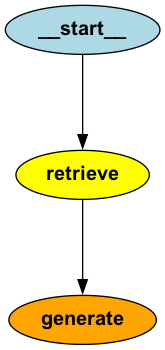

In [73]:
from IPython.display import Image

Image(graph.get_graph().draw_png())